In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
import ncvis
import numpy as np
import os
from plotting import plot_digit_samples, get_samples
%matplotlib inline

device = "cuda:0" if torch.cuda.is_available() else "cpu" 

In [2]:
data = ['mnist', 'goodreads']

In [39]:
####################################
general_name = 'data_mnist_skips_False_prior_NAF_numnafs_1_samples_1_zdim_64'
####################################

### Prior plotting

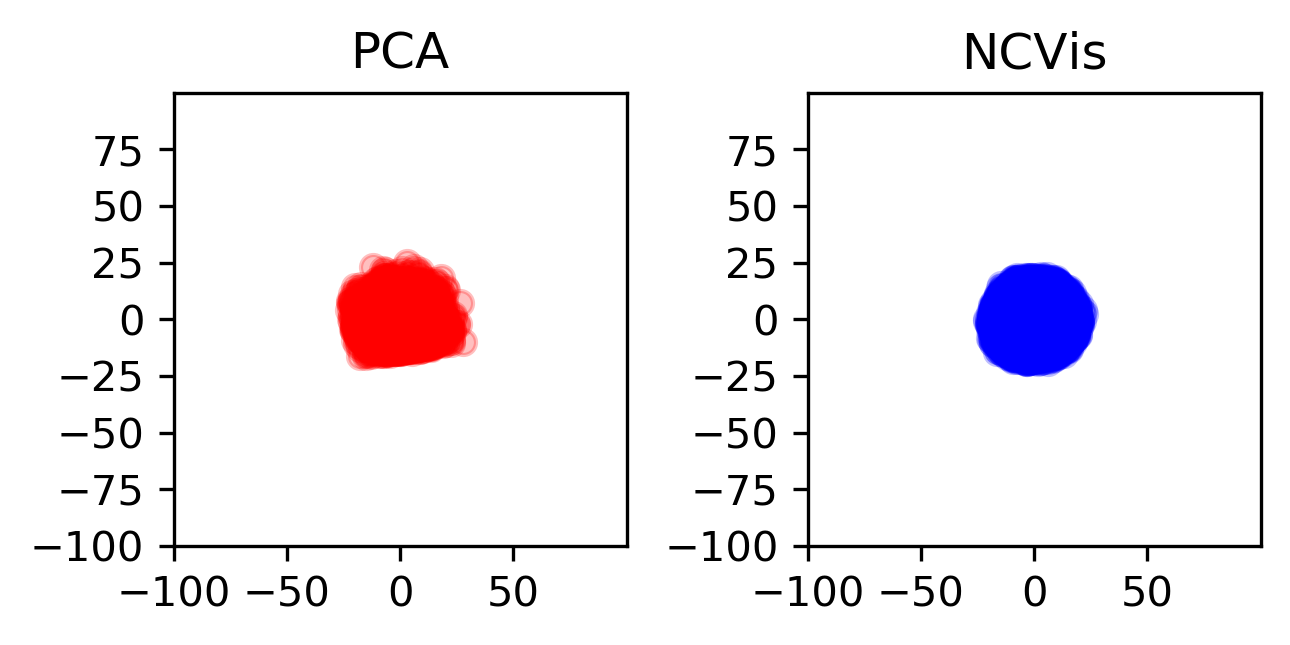

In [40]:
filename = 'prior_{}'.format(general_name + '.txt')
full_name = os.path.join('./plot_data/mnist', filename)
if os.path.exists(full_name):
    file = open(full_name)
    data = np.array([float(val) for val in ' '.join([value for value in file.read().split('\n')][:-1]).split(' ')]).reshape(-1, 64)
    fig, ax = plt.subplots(ncols=2, figsize=(5, 2), dpi=300, sharex=True)
    limx, limy = 100, 100
    #### PCA ####
    pca = PCA(n_components=2)
    compressed_data = pca.fit_transform(data)
    ax[0].set_title('PCA')
    ax[0].scatter(compressed_data[:, 0], compressed_data[:, 1], c='r', alpha=0.25)
    ax[0].set_xlim((-limx, limx))
    ax[0].set_ylim((-limy, limy))
    ax[0].set_xticks(np.arange(-limx, limx, 50))
    ax[0].set_yticks(np.arange(-limy, limy, 25))
    ax[0].set_aspect('equal', 'box')

    ### NCVIS ###
    vis = ncvis.NCVis()
    compressed_data = vis.fit_transform(data)
    ax[1].set_title('NCVis')
    ax[1].scatter(compressed_data[:, 0], compressed_data[:, 1], c='b', alpha=0.25)
    ax[1].set_xlim((-limx, limx))
    ax[1].set_ylim((-limy, limy))
    ax[1].set_xticks(np.arange(-limx, limx, 50))
    ax[1].set_yticks(np.arange(-limy, limy, 25))
    ax[1].set_aspect('equal', 'box')
else:
    print('NO data found!')

### Samples plotting

In [41]:
filename = 'best_decoder_{}'.format(general_name + '.pt')
full_name = os.path.join('./models/mnist', filename)
if os.path.exists(full_name):
    decoder = torch.load(full_name, map_location=device)
else:
    decoder = None

In [42]:
filename = 'best_encoder_{}'.format(general_name + '.pt')
full_name = os.path.join('./models/mnist', filename)
if os.path.exists(full_name):
    encoder = torch.load(full_name, map_location=device)
else:
    encoder = None

In [43]:
filename = 'best_prior_{}'.format(general_name + '.pt')
full_name = os.path.join('./models/mnist', filename)
if os.path.exists(full_name):
    prior = torch.load(full_name, map_location=device)
else:
    prior = None

In [44]:
decoder

Decoder(
  (linear1): Linear(in_features=64, out_features=450, bias=True)
  (linear2): Linear(in_features=450, out_features=512, bias=True)
  (deconv1): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (deconv2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)

In [45]:
encoder

Encoder(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (linear): Linear(in_features=512, out_features=450, bias=True)
  (mu): Linear(in_features=450, out_features=64, bias=True)
  (sigma): Linear(in_features=450, out_features=64, bias=True)
)

In [46]:
prior

ModuleList(
  (0): NeuralAutoregressive()
)

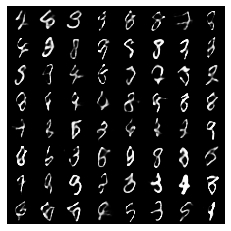

In [47]:
random_code = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device)).sample((64, 64))
if prior:
    for i in range(len(prior)):
        random_code = prior[i](random_code)
plot_digit_samples(get_samples(gen_network=decoder, device=device))